#  Прогнозирование вероятности оттока пользователей для фитнес-центров

# Содержание

Часть 1. Описание проекта.<br>

* 1. Описание исследования
* 2. Цель исследования

Часть 2. Проведение исследовательского анализа данных (EDA).<br>

* 1. Изучение данных

Часть 3. Построение модели прогнозирования оттока клиентов.<br>

* 1. Разделение данных на обучающую и валидационную выборку
* 2. Обучение модели

Часть 4. Кластеризация клиентов.<br>

* 1. Стандартизация данных
* 2. Матрица расстояний
* 3. Обучение модели
* 4. Оценка доли оттока в разных кластерах 

Часть 5. Выводы.<br>

* 1. Общий вывод по работе

## Часть. Описание проекта
### Описание исследования

Помочь сети фитнес-центров разработать стратегию взаимодействия с клиентами, изпользуя предоставленные данные. 

Данные клиента за предыдущий до проверки факта оттока месяц:<br>
`gender` — пол<br>
`Near_Location` — проживание или работа в районе, где находится фитнес-центр<br>
`Partner` — сотрудник компании-партнёра клуба<br>
`Promo_friends` — факт первоначальной записи в рамках акции «приведи друга»<br>
`Phone` — наличие контактного телефона<br>
`Age` — возраст<br>
`Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах)<br>

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:<br>
`Contract_period` — длительность текущего действующего абонемента (месяц, 6 месяцев, год)<br>
`Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах)<br>
`Group_visits` — факт посещения групповых занятий<br>
`Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента<br>
`Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц<br>
`Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра<br>
`Churn` — факт оттока в текущем месяце<br>

### Цель исследования
1. Cпрогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента
2. Cформировать типичные портреты клиентов
3. Выделить основные признаки, наиболее сильно влияющие на отток
4. Разработать рекомендации по повышению качества работы с клиентами

## Часть. Проведение исследовательского анализа данных (EDA)
### Изучение данных

In [1]:
# Подключение библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from scipy.cluster.hierarchy import dendrogram, linkage 
from sklearn.cluster import KMeans

pd.options.mode.chained_assignment = None
pd.set_option('display.float_format', '{:.4f}'.format)

In [2]:
# Чтение файла с данными
gym_data = pd.read_csv('/datasets/gym_churn.csv')

In [3]:
# Функция для вывода основных данных по датасету
def all_info(data):
    print('Общая информация')
    data.info() #вывод общей информации
    display('Первые значения', data.head(5)) #вывод первых 10 значений
    display('Описание данных', data.describe()) #вывод описательной статистики по датасету
    display('Дубликаты', data.duplicated().sum()) #поиск явных дубликатов в данных
    display('Пропуски', data.isna().mean().apply('{:.2%}'.format)) #подсчет пропусков в датасете в %
    print('*'*50)
    
# Применение функции к данным
all_info(gym_data)

Общая информация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000

'Первые значения'

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.2275,5.0000,3,0.0204,0.0000,0
1,0,1,0,0,1,12,1,31,113.2029,12.0000,7,1.9229,1.9102,0
2,0,1,1,0,1,1,0,28,129.4485,1.0000,2,1.8591,1.7365,0
3,0,1,1,1,1,12,1,33,62.6699,12.0000,2,3.2056,3.3572,0
4,1,1,1,1,1,1,0,26,198.3623,1.0000,3,1.1139,1.1201,0


'Описание данных'

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.0000,4000.0000,4000.0000,4000.0000,4000.0000,4000.0000,4000.0000,4000.0000,4000.0000,4000.0000,4000.0000,4000.0000,4000.0000,4000.0000
mean,0.5102,0.8452,0.4868,0.3085,0.9035,4.6813,0.4123,29.1842,146.9437,4.3228,3.7247,1.8790,1.7671,0.2652
std,0.5000,0.3617,0.4999,0.4619,0.2953,4.5497,0.4923,3.2584,96.3556,4.1913,3.7493,0.9722,1.0529,0.4415
min,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,18.0000,0.1482,1.0000,0.0000,0.0000,0.0000,0.0000
25%,0.0000,1.0000,0.0000,0.0000,1.0000,1.0000,0.0000,27.0000,68.8688,1.0000,1.0000,1.1809,0.9630,0.0000
50%,1.0000,1.0000,0.0000,0.0000,1.0000,1.0000,0.0000,29.0000,136.2202,1.0000,3.0000,1.8328,1.7196,0.0000
75%,1.0000,1.0000,1.0000,1.0000,1.0000,6.0000,1.0000,31.0000,210.9496,6.0000,5.0000,2.5361,2.5103,1.0000
max,1.0000,1.0000,1.0000,1.0000,1.0000,12.0000,1.0000,41.0000,552.5907,12.0000,31.0000,6.0237,6.1468,1.0000


'Дубликаты'

0

'Пропуски'

gender                               0.00%
Near_Location                        0.00%
Partner                              0.00%
Promo_friends                        0.00%
Phone                                0.00%
Contract_period                      0.00%
Group_visits                         0.00%
Age                                  0.00%
Avg_additional_charges_total         0.00%
Month_to_end_contract                0.00%
Lifetime                             0.00%
Avg_class_frequency_total            0.00%
Avg_class_frequency_current_month    0.00%
Churn                                0.00%
dtype: object

**************************************************


Данные состояк из 4000 строк и 14 колонок.При первом взгляде можно сказать об отсутствии дубликатов и пропусков в данных, также типы данных в колонках соответствуют их содержимому.

Для удобства приведем наименования колонок к нижнему регистру.

In [4]:
# Приведение наименований колонок к нижнему регистру (для удобства)
gym_data.columns = gym_data.columns.str.lower()
# Проверка результата
gym_data.columns

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn'],
      dtype='object')

В рамках проведения исследовательского анализа данных сформируем 2 группы: ушедшие и оставшиеся клиенты, для групп рассмотрим средние значения каждого признака.

In [5]:
# Рассчет средних значений в группах в зависимости от оттока
gym_data.groupby('churn', as_index=False).mean().T.rename(columns={0: 'Оставшиеся', 1: 'Ушедшие'})

,Оставшиеся,Ушедшие
churn,0.0000,1.0000
gender,0.5100,0.5108
near_location,0.8731,0.7681
partner,0.5342,0.3553
promo_friends,0.3535,0.1838
phone,0.9037,0.9029
contract_period,5.7472,1.7286
group_visits,0.4641,0.2686
age,29.9765,26.9896
avg_additional_charges_total,158.4457,115.0829


По полученным средним значениям можно сказать следующее:

1) Большая часть ушедших не являются сотрудниками компании-партнера клуба ("люди с улицы")<br>
2) Среднее значение длительности абонемента у ушедших 1.7, скорее всего большая часть ушедших клиентов брала абонемент на месяц<br>
3) Средний возраст ушедших 27 лет<br>
4) Средний срок до окончания абонемента 1.6, на основании этого и пункта 2 можно предположить, что ушедшие клиенты занимались всего пару занятий, об этом также говорит низкий показатель лайфтайма и средния частота посещений в неделю<br>

Для большей наглядности построим гисторграммы каждого признака для оставшихся и ушедших клиентов. Также построим таблицу корреляции признаков.

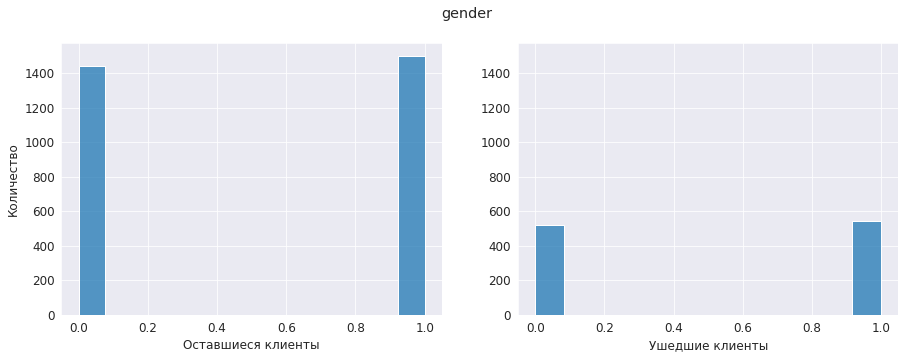

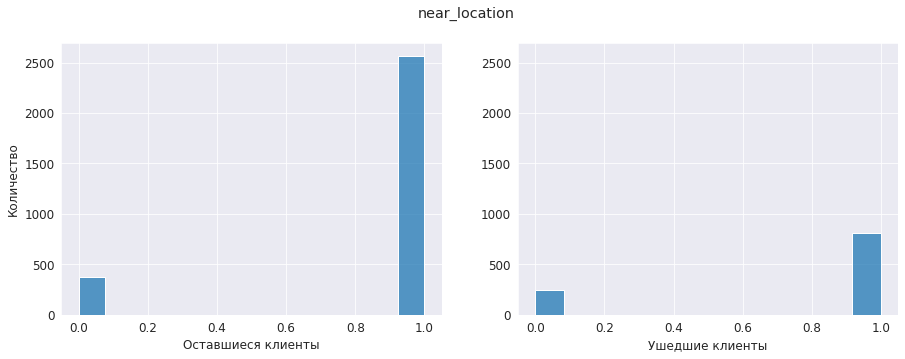

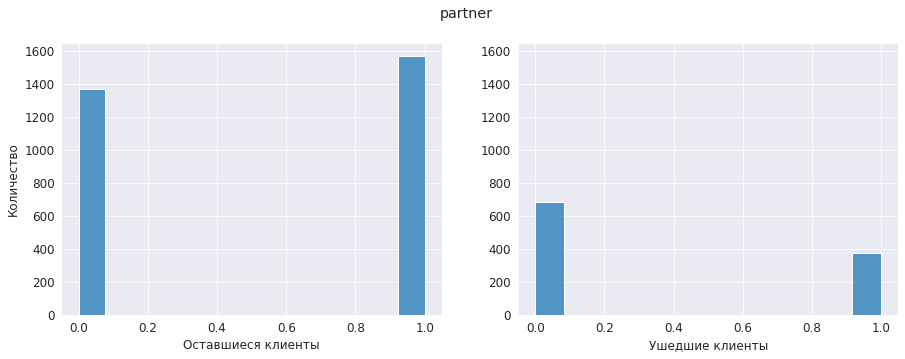

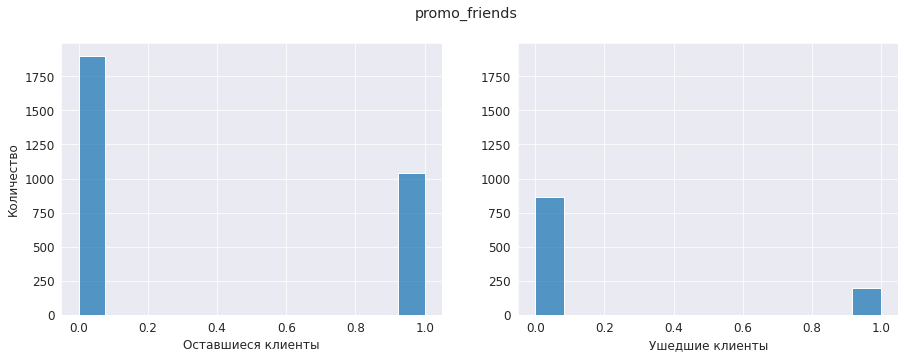

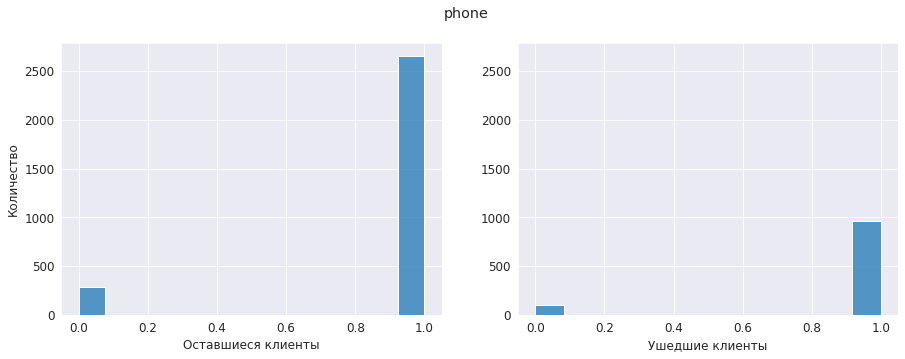

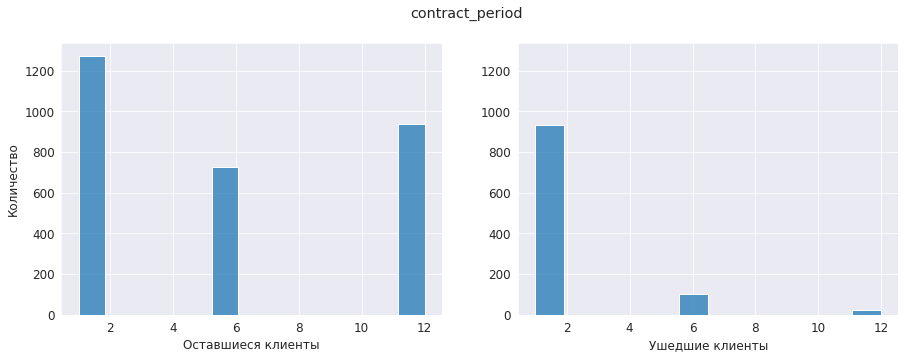

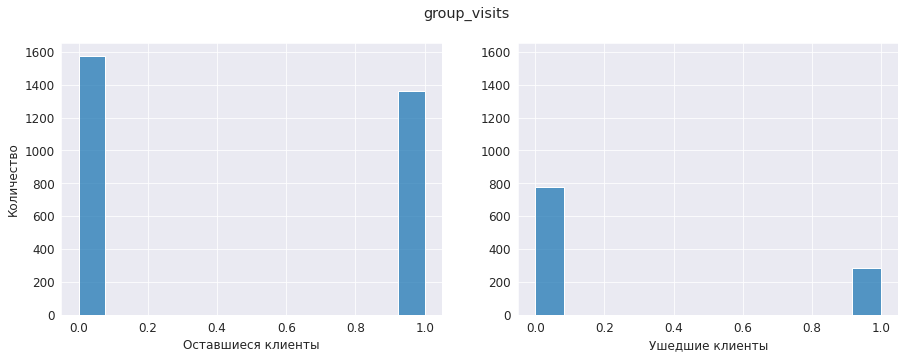

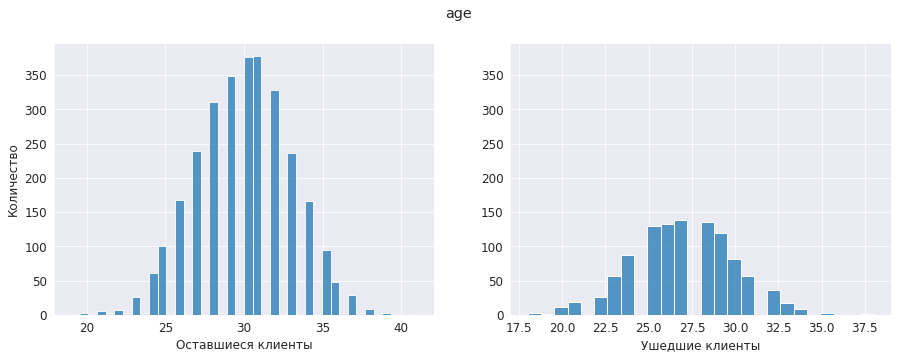

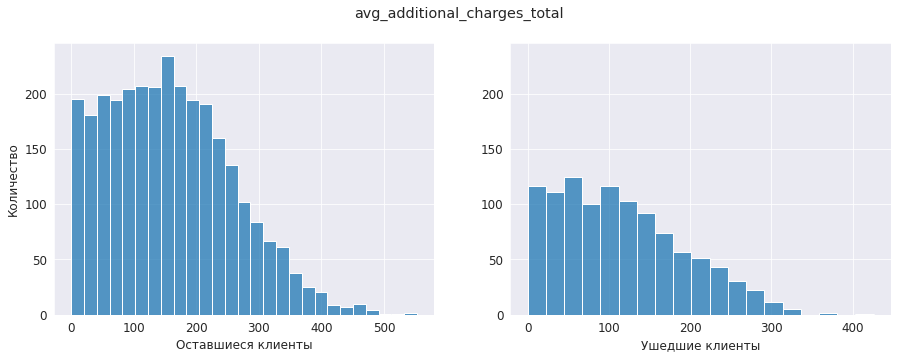

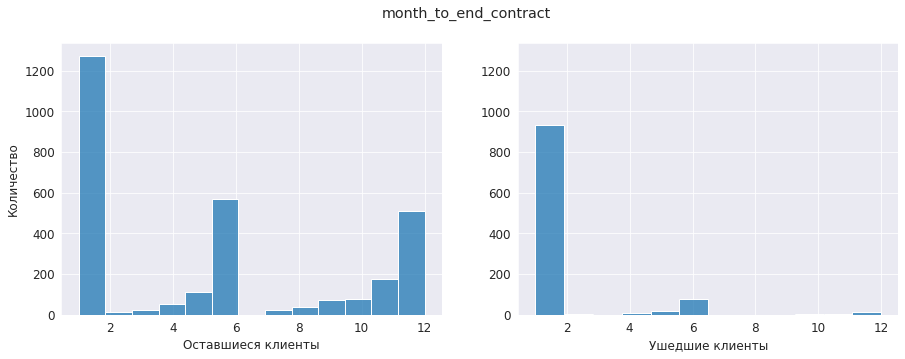

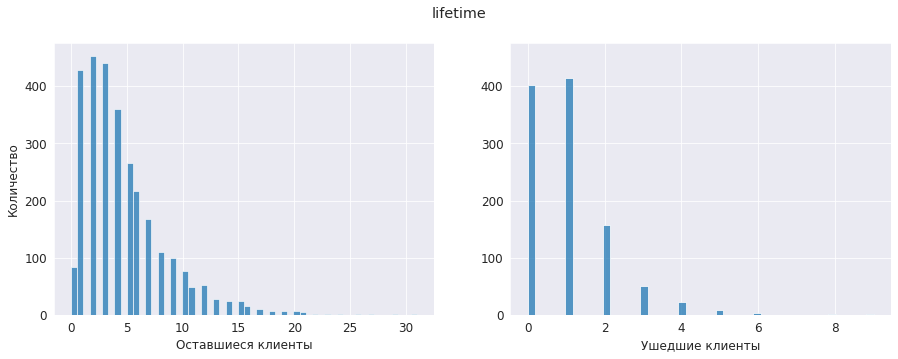

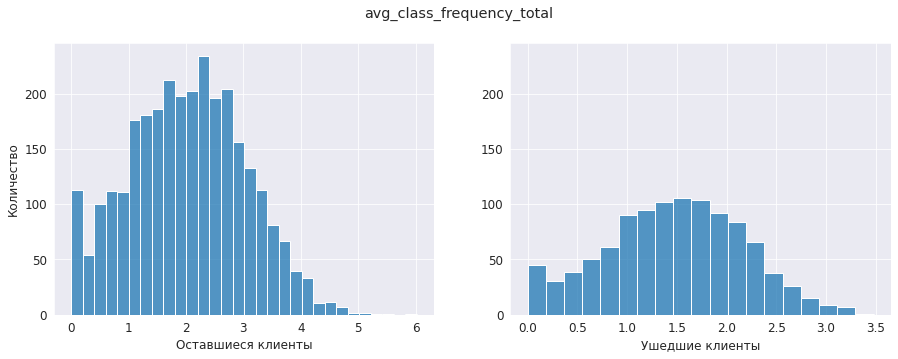

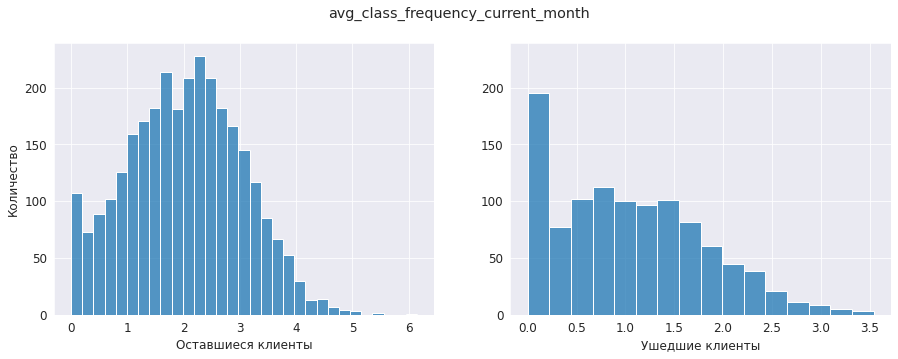

In [6]:
# Построение гистограмм и распределений признаков для оставшихся и ушедших клиентов

# Выделение группы оставшихся клиентов
churn_0 = gym_data.query('churn == 0')
churn_0.drop(columns=['churn'], inplace=True)

# Выделение группы ушедших клиентов
churn_1 = gym_data.query('churn == 1')
churn_1.drop(columns=['churn'], inplace=True)

# Настройки графиков
plt.rcParams['font.size'] = '12'
sns.set_style("darkgrid")

# Цикл, который проходит по признакам в таблице (признаки в 2х таблицах одинаковые) и 
# строит пару гистограмм "оставшиеся/ушедшие"
for column in churn_0.columns:
    plt.figure(figsize=(15, 5))
    
    # Гистограмма оставшихся
    ax1 = plt.subplot(1, 2, 1)
    sns.histplot(data=churn_0, x=column)
    plt.xlabel('Оставшиеся клиенты')
    plt.ylabel('Количество')
    
    # Гистограмма ушедших
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    sns.histplot(data=churn_1, x=column)
    plt.xlabel('Ушедшие клиенты')
    plt.ylabel('')
    
    plt.suptitle(column)
    plt.show()

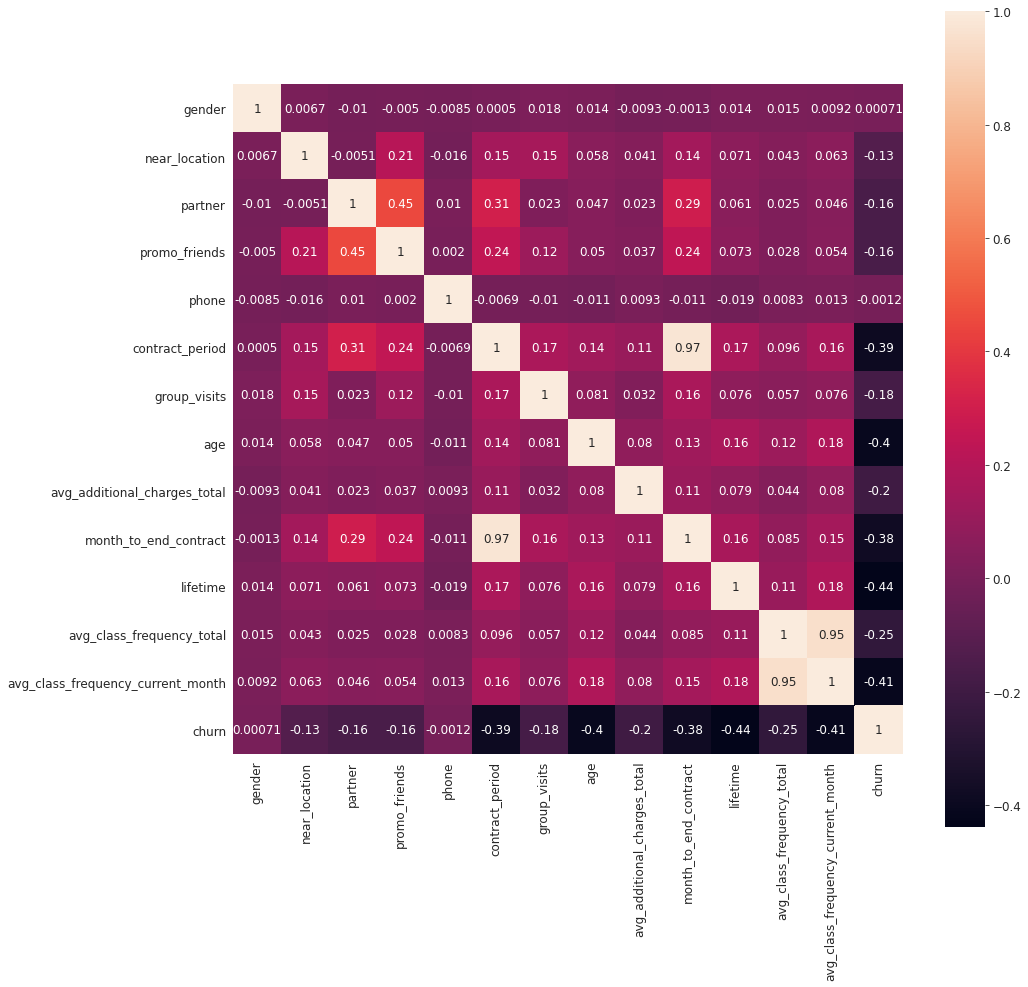

In [7]:
# Построение матрицы корреляции
corr = gym_data.corr()
plt.figure(figsize=(15, 15))
sns.heatmap(corr, square=True, annot=True)
plt.show()

Основными коррелирующими признаками являются:

1) Лайфтайм и длительность текущего абонемента<br>
2) Средняя частота посещений в неделю за все время и средняя частота посещений в неделю за предыдущий месяц<br>

**Выводы**

По рассмотренным средним значениям можно и построенным гистограммам можно сказать следующее:

1) Большая часть ушедших не являются сотрудниками компании-партнера клуба ("люди с улицы")<br>
2) Среднее значение длительности абонемента у ушедших 1.7, скорее всего большая часть ушедших клиентов брала абонемент на месяц<br>
3) Средний возраст ушедших 27 лет<br>
4) Средний срок до окончания абонемента 1.6, на основании этого и пункта 2 можно предположить, что ушедшие клиенты занимались всего пару занятий, об этом также говорит низкий показатель лайфтайма и средния частота посещений в неделю<br>

Основными коррелирующими признаками являются:

1) Лайфтайм и длительность текущего абонемента<br>
2) Средняя частота посещений в неделю за все время и средняя частота посещений в неделю за предыдущий месяц<br>

## Часть. Построение модели прогнозирования оттока клиентов
### Разделение данных на обучающую и валидационную выборку

Для обучения моделей разделим данные на две выборки:
1) обучающая, на которой будем обучать модели<br>
2) валидационная, на которой будем проверять работу моделей.

In [8]:
# Выделение признаков
X = gym_data.drop(columns=['churn'])
# Выделение целевой переменной
y = gym_data['churn']

# Разделение модели на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=0)

### Обучение модели

В данной работе будем использовать 2 модели: логистическую регрессию и случайное дерево. После обучения оценим работу моделей с помощью метрик `accuracy`, `precision`, `recall`.

In [9]:
# Список моделей, по которым будет обучаться выборка
models = [LogisticRegression(solver='liblinear', random_state=0), RandomForestClassifier(random_state=0)]

# Функция выводящая метрики
def make_prediction(m, X_train, y_train, X_test, y_test):
    model = m
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(
        'Accuracy:{:.2f} \nPrecision:{:.2f} \nRecall:{:.2f} \n'.format(
            accuracy_score(y_test, y_pred),
            precision_score(y_test, y_pred),
            recall_score(y_test, y_pred)
        )
    )
    
# Цикл по моделям
for i in models:
    print(i)
    make_prediction(
        m=i,
        X_train=X_train,
        y_train=y_train,
        X_test=X_test,
        y_test=y_test
    )

LogisticRegression(random_state=0, solver='liblinear')
Accuracy:0.93 
Precision:0.89 
Recall:0.84 

RandomForestClassifier(random_state=0)
Accuracy:0.92 
Precision:0.88 
Recall:0.83 



**Выводы**

Логистическая регрессия показывает немного лучшие значения метрик в отличии от случайного леса.

## Часть. Кластеризация клиентов
### Стандартизация данных

Прежде чем выполнять кластеризацию, стоит привести веса всех признаков к одному виду, для этого данные необходимо стандартизировать, воспользуемся методом `StandardScaler`.

In [10]:
# Создание объекта класса стандартизации
scaler = StandardScaler()

# Обучение стандартизатора
X_train_st = scaler.fit_transform(gym_data)

### Матрица расстояний

Построим матрицу расстояний и визуализируем ее с помощью дендрограммы.

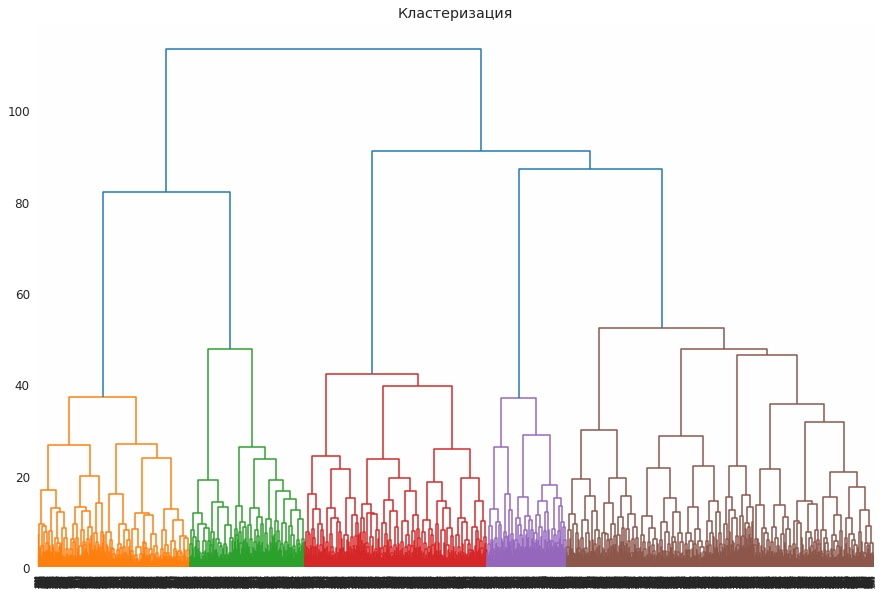

In [11]:
# Матрица расстояний
link = linkage(X_train_st, method = 'ward') 

# Построение дендрограммы 
plt.figure(figsize=(15, 10))  
dendrogram(link, orientation='top')
plt.title('Кластеризация')
plt.show() 

Исходя из разных цветов на дендрограмме, оптимальное количество кластеров - 5.

### Обучение модели

Для кластеризации воспользуемся алгоритмом KMean и на основании дендрограммы зададим оптимальное количество кластеров.

In [12]:
# Задаём число кластеров равное 5
kmean = KMeans(n_clusters=5, random_state=0) 
# Применяем алгоритм к данным и формируем вектор кластеров 
labels = kmean.fit_predict(X_train_st) 

### Оценка доли оттока в разных кластерах

In [13]:
# Сохранение меток кластера
gym_data['cluster'] = labels
# Рассчет средних значений признаков в каждом кластере
gym_data.groupby('cluster', as_index=False).mean().T

,0,1,2,3,4
cluster,0.0000,1.0000,2.0000,3.0000,4.0000
gender,0.5037,0.4928,0.5079,0.5212,0.5189
near_location,0.0000,0.9361,1.0000,0.9966,0.9680
partner,0.4596,0.7640,0.3240,0.2822,0.7442
promo_friends,0.0754,0.5346,0.2132,0.2085,0.5262
phone,0.9173,0.9192,0.9038,0.9042,0.8735
contract_period,2.0699,10.4472,1.5469,1.8822,8.8590
group_visits,0.2114,0.5163,0.2875,0.4525,0.5349
age,28.5221,29.9622,26.9269,30.2373,29.7282
avg_additional_charges_total,132.7412,161.8536,113.1731,157.9886,162.9075


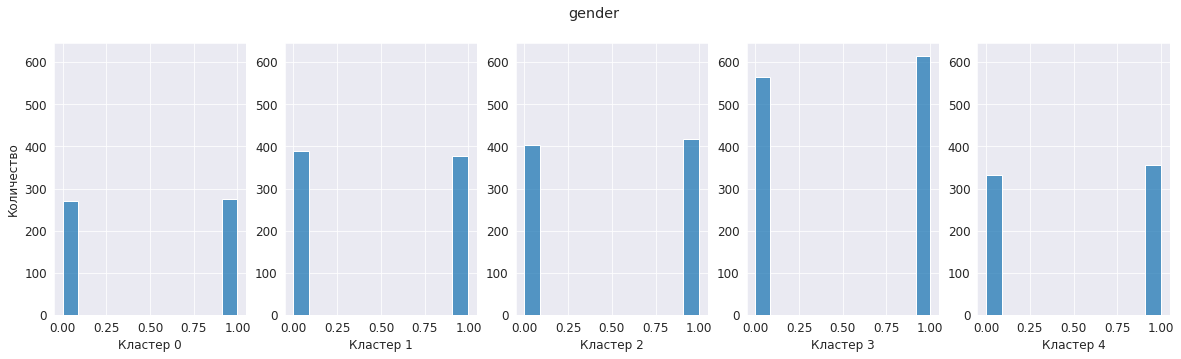

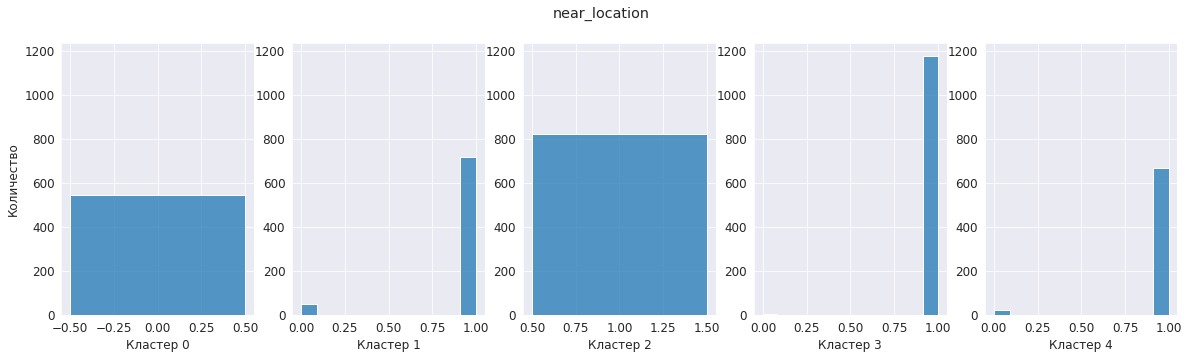

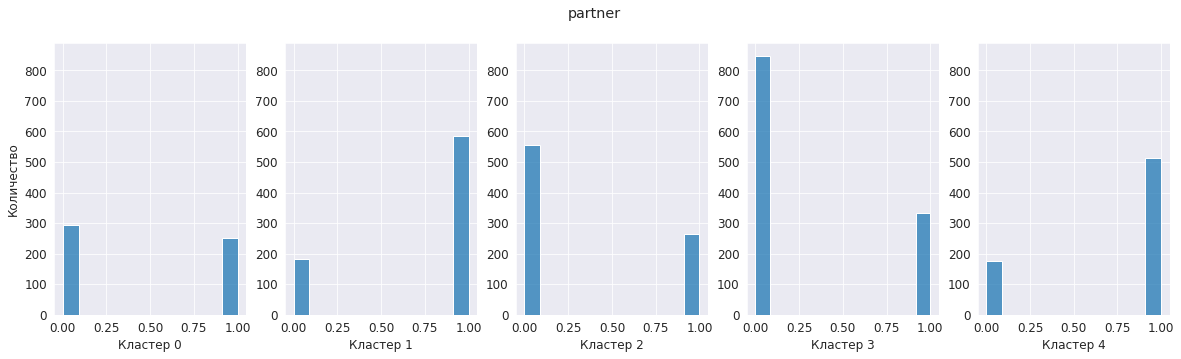

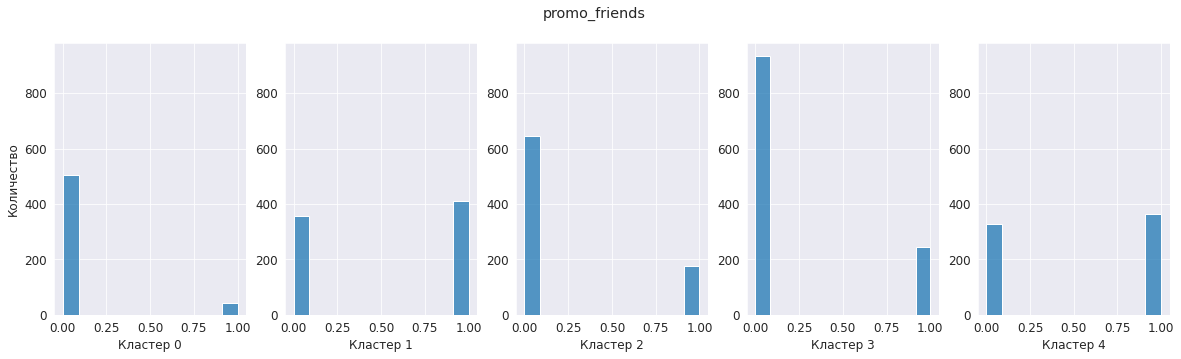

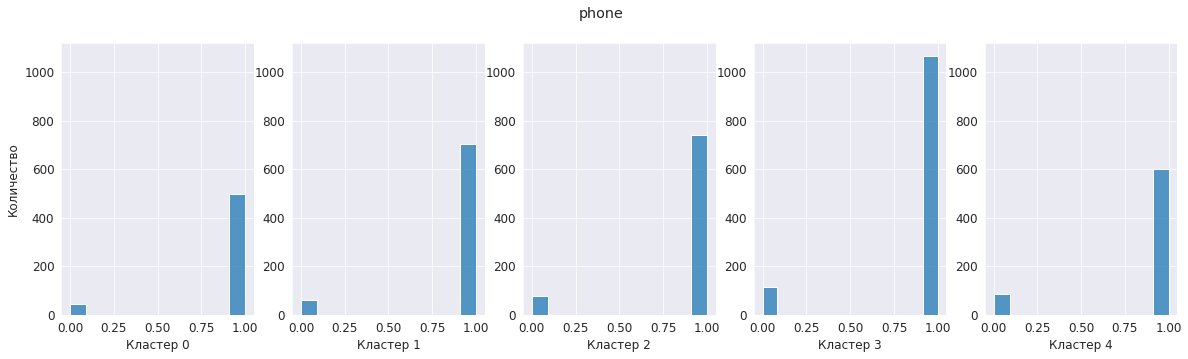

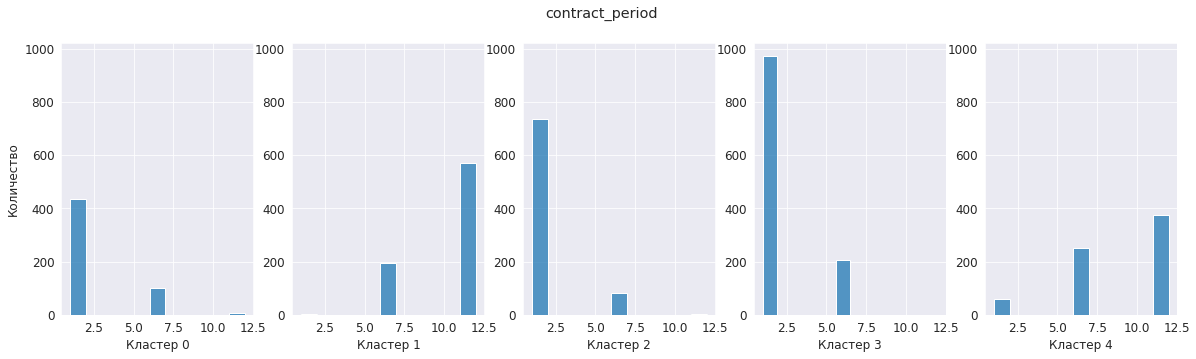

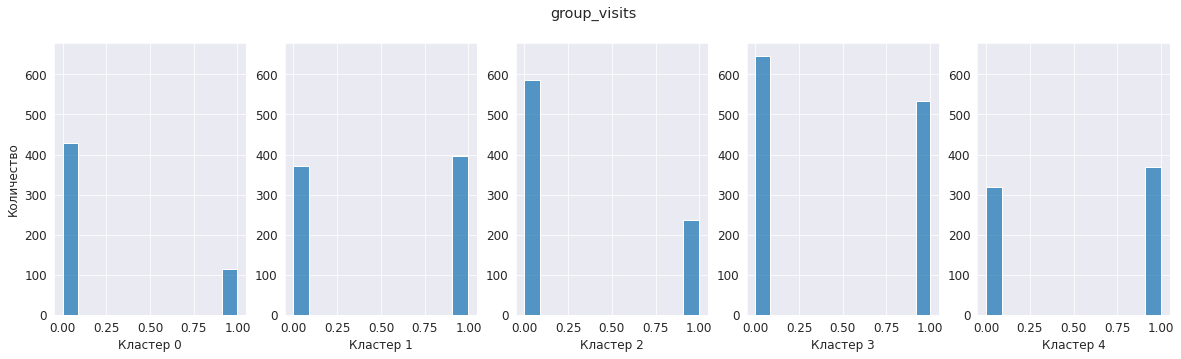

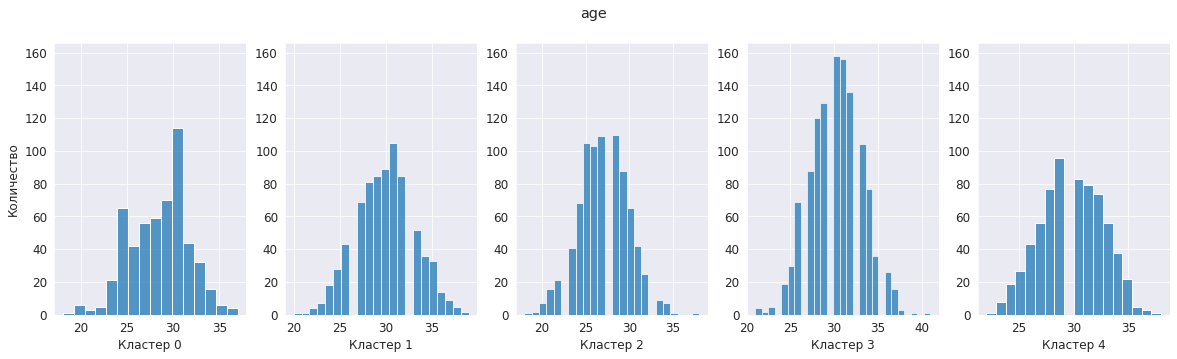

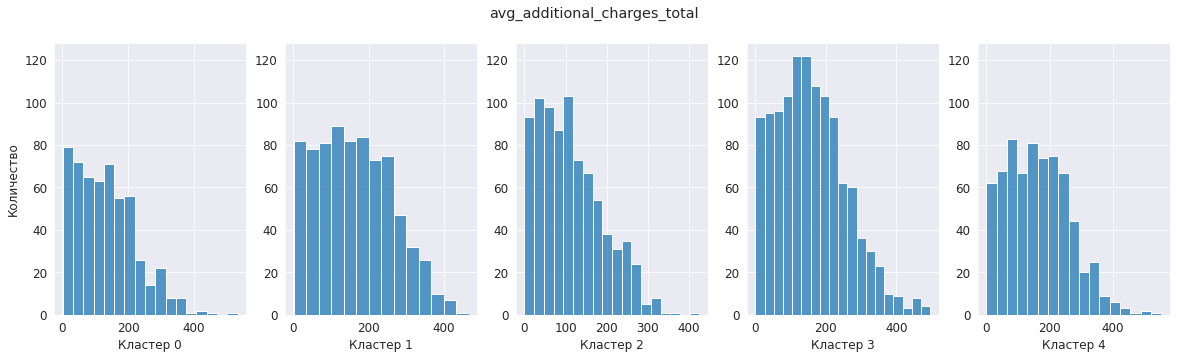

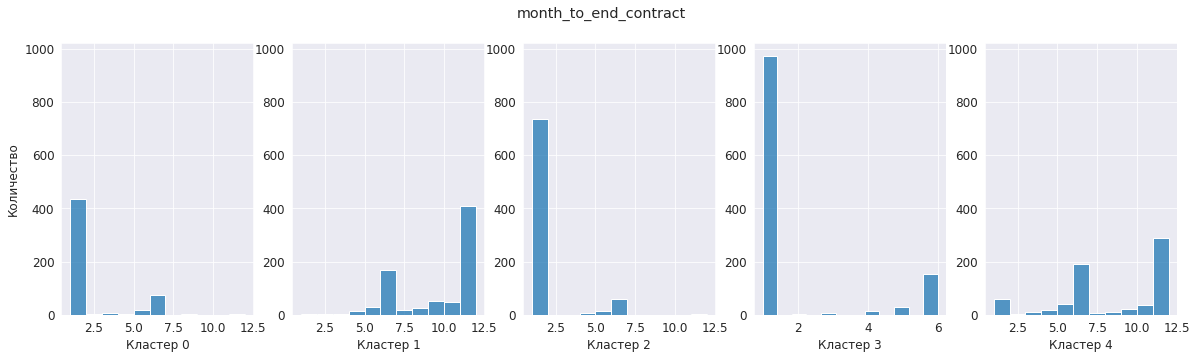

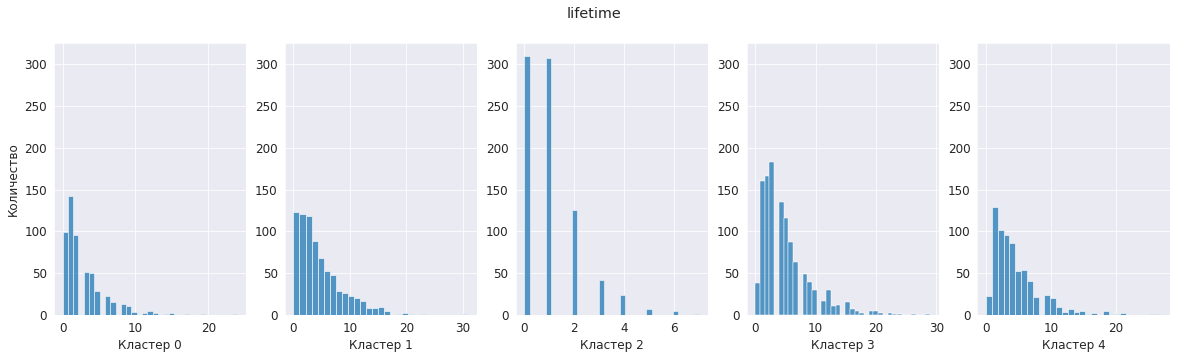

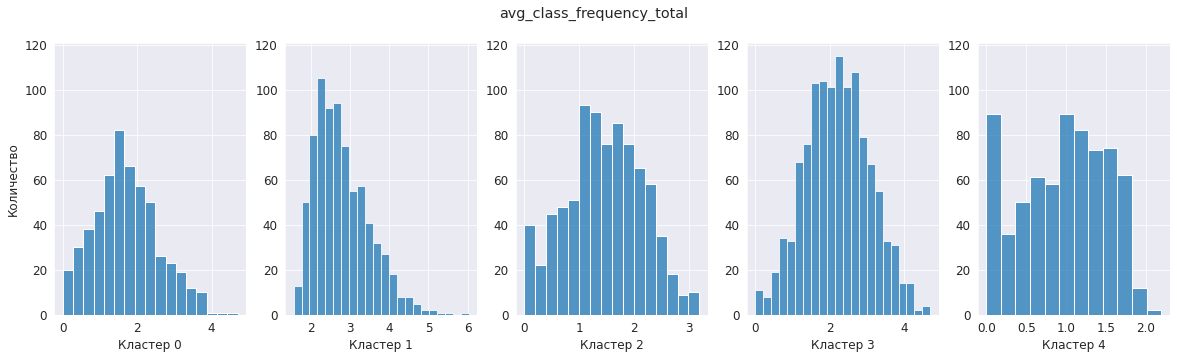

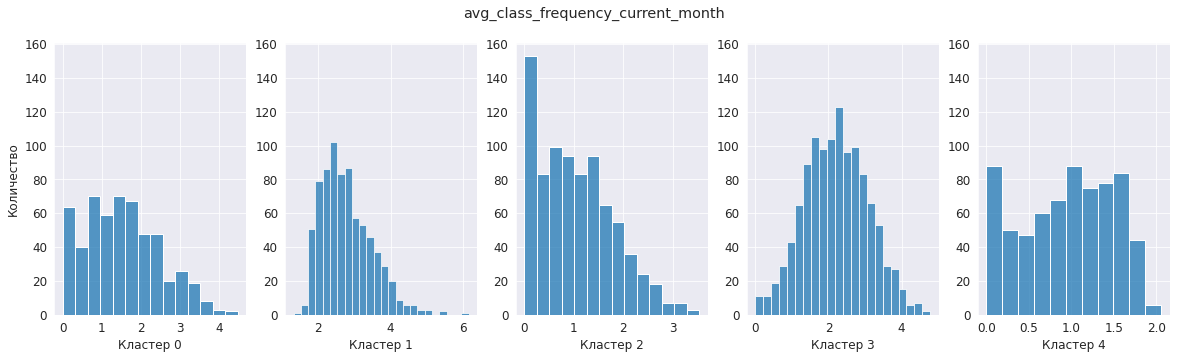

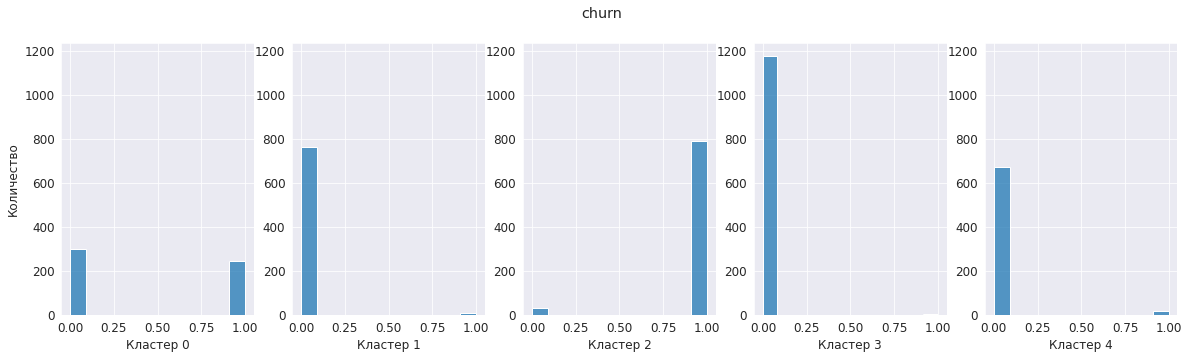

In [14]:
# Построение гистограмм и распределений признаков для оставшихся и ушедших клиентов

# Кластер 0
cluster_0 = gym_data.query('cluster == 0')
cluster_0.drop(columns=['cluster'], inplace=True)

# Кластер 1
cluster_1 = gym_data.query('cluster == 1')
cluster_1.drop(columns=['cluster'], inplace=True)

# Кластер 2
cluster_2 = gym_data.query('cluster == 2')
cluster_2.drop(columns=['cluster'], inplace=True)

# Кластер 3
cluster_3 = gym_data.query('cluster == 3')
cluster_3.drop(columns=['cluster'], inplace=True)

# Кластер 4
cluster_4 = gym_data.query('cluster == 4')
cluster_4.drop(columns=['cluster'], inplace=True)

# Настройки графиков
plt.rcParams['font.size'] = '12'
sns.set_style("darkgrid")

# Цикл, который проходит по признакам в таблице (признаки в таблицах одинаковые) и строит гистограммs 
for column in cluster_0.columns:
    plt.figure(figsize=(20, 5))
    
    # Гистограмма кластера 0
    ax1 = plt.subplot(1, 5, 1)
    sns.histplot(data=cluster_0, x=column)
    plt.xlabel('Кластер 0')
    plt.ylabel('Количество')
    
    # Гистограмма кластера 1
    ax2 = plt.subplot(1, 5, 2, sharey=ax1)
    sns.histplot(data=cluster_1, x=column)
    plt.xlabel('Кластер 1')
    plt.ylabel('')
    
    # Гистограмма кластера 2
    ax3 = plt.subplot(1, 5, 3, sharey=ax1)
    sns.histplot(data=cluster_2, x=column)
    plt.xlabel('Кластер 2')
    plt.ylabel('')
    
    # Гистограмма кластера 3
    ax4 = plt.subplot(1, 5, 4, sharey=ax1)
    sns.histplot(data=cluster_3, x=column)
    plt.xlabel('Кластер 3')
    plt.ylabel('')
    
    # Гистограмма кластера 4
    ax5 = plt.subplot(1, 5, 5, sharey=ax1)
    sns.histplot(data=cluster_4, x=column)
    plt.xlabel('Кластер 4')
    plt.ylabel('')
    
    plt.suptitle(column)
    plt.show()

In [15]:
# Рассчет средних значений оттока для каждого из кластера
gym_data.groupby('cluster', as_index=False)['churn'].mean().rename(columns={'churn': 'mean'}).T

,0,1,2,3,4
cluster,0.0000,1.0000,2.0000,3.0000,4.0000
mean,0.4504,0.0078,0.9610,0.0034,0.0247


In [16]:
# Количество клиентов каждой группы
gym_data.groupby('cluster', as_index=False)['churn'].count().rename(columns={'churn': 'count'}).T

,0,1,2,3,4
cluster,0,1,2,3,4
count,544,767,821,1180,688


**Выводы**

По рассмотренным средним значениям можно и построенным гистограммам можно сказать следующее:

1) Надежными кластерами являются 1, 3 и 4, при этом 3 самый надежный.<br>
2) Кластеры 1 и 4 имеют схожие признаки за исключением частоты посещения для 1 кластера в среднем 2 занятия в неделю, для 4 - 1. При этом в данные кластеры входят в основно клиенты-партнеры или те, кто пришел по акции "приведи друга". Большинстов клиентов данных кластеров берут абонементы на 12 месяцев. Также это самые прибыльные кластеры.<br>
3) Средний возраст клиентов кластера 3 - 30 лет. К тому же у клиентов данного кластера самый высокий лайфтайм и наименьший отток.<br>
4) Кластер с самым больщим оттоком - 2. Это самый "молодой" кластер, к тому же клиенты, относящиеся к нему, как правило берут абонемент на месяц.<br>
5) Кластер 0 является некоторым средним кластером среди всех по всем признакам.

## Часть. Выводы
### Общий вывод по работе



1) Самыми надежными кластерами являются 1, 3 и 4, при этом 3 самый надежный.<br>
2) Средний возраст клиентов кластера 3 - 30 лет. К тому же у клиентов данного кластера самый высокий лайфтайм и наименьший отток.<br>
3) Кластер с самым большим оттоком - 2. Это самый "молодой" кластер, к тому же клиенты, относящиеся к нему, как правило берут абонемент на месяц.
4) Кластер 0 является некоторым средним кластером среди всех по всем признакам.

Если говорить о закономерностях, то основным фактором постоянства клиента является лайфтайм: чем дольше клиент посещает зал, тем меньше вероятность его оттока, что как раз и видно по таблице средних значений - у надежных кластеров лайфтайм почти 5 месяцев, у "неуверенного" (кластер 0) - 2 месяца, а у "отточного" (кластер 2) всего 1 месяц.<br>
В качестве доп. фактора можно отметить возраст, т.к. клиентам надежных кластеров 30 лет, а у "отточного" самые молодые клиенты.<br>
Также о надежности клиента можно сказать по абонементу, на какой период он его берет (кластеры 1 и 4).

В качестве рекомендаций можно предложить следующее:<br>
1) Для новых клиентов можно сделать большую скидку для абонемента на 6 месяцев, возможно это увеличит лайфтайм и, как следствие, "поможет втянуться в тренировки".<br>
2) Можно ввести новые акции, кроме "приведи друга".<br>
3) Расширять партнерку.